In [1]:
import pandas as pd
import os
import glob

# Specify the path to your main folder containing subfolders with CSV files
main_path = r'C:\ResearchFiles\AllFiles_Cleaned'

# Recursively search for all CSV files in the subfolders
all_files = [f for f in glob.glob(os.path.join(main_path, "**/*.csv"), recursive=True)]

# Combine all files into a single DataFrame
df_list = []
for filename in all_files:
    df = pd.read_csv(filename)
    df['smart_plug'] = os.path.basename(filename).split('_')[1]  # Add a column for the smart plug identifier
    # Optionally, add a column for the building by extracting from the path
    df['building'] = os.path.basename(os.path.dirname(filename))
    df_list.append(df)

combined_df = pd.concat(df_list, ignore_index=True)

In [2]:
# Remove unneccessary columns
combined_df = combined_df.drop(columns = ['analogInput_2', 'analogInput_4', 'analogInput_5', 'binaryInput_3', 'binaryValue_1', 'building'])

# Convert timestamp column to datetime
combined_df['time'] = pd.to_datetime(combined_df['time'])

# Rename the power consumption column more appropriately
combined_df = combined_df.rename(columns = {'analogInput_3': 'power_consumption (mW)'})

# Read in a dataset of abnormal readings to filter for only plugs without any abnormal readings
abnormal_readings = pd.read_csv(r'C:\Users\vaugh\Downloads\helper_spreadsheet(8).csv')
abnormal_readings.drop(columns=['numer_ids'], inplace=True)
abnormal_readings['smart_plug'] = abnormal_readings['smart_plug'].astype(str)
abnormal_readings['smart_plug'] = abnormal_readings['smart_plug'].apply(lambda x: x[:-2])

# Combining the datasets to include the abnormal readings column and setting time as the index
combined_df = combined_df.merge(abnormal_readings, on='smart_plug')
combined_df = combined_df[combined_df['Abnormal Readings'] == 'Clear']
combined_df.drop(columns = ['Abnormal Readings'], inplace=True)

# Set the timestamp as index for easier use when graphing
combined_df.set_index('time', inplace=True)

In [3]:
combined_df

,power_consumption (mW),smart_plug
time,,
2023-09-15 17:25:00,0.0,182280
2023-09-15 17:26:00,0.0,182280
2023-09-15 17:27:00,0.0,182280
2023-09-15 17:28:00,0.0,182280
2023-09-15 17:29:00,0.0,182280
...,...,...
2024-06-10 23:55:00,20587.0,657128
2024-06-10 23:56:00,21240.0,657128
2024-06-10 23:57:00,20760.0,657128


In [4]:
# Resample to monthly intervals for easier graphing abilities
monthly_df = combined_df.resample('M').mean(numeric_only=True)

# Convert all power consumption values from milliWatt to KW/h and rename appropriately
monthly_df['power_consumption (mW)'] = monthly_df['power_consumption (mW)']/ 1_000_000
monthly_df.rename(columns = {'power_consumption (mW)': 'power_consumption (KW)'}, inplace=True)

# Mutliplying the mean values per day by the number of plugs to get the total KW production from all plugs
monthly_df['power_consumption (KW)'] = monthly_df['power_consumption (KW)'] * combined_df['smart_plug'].nunique()

In [5]:
monthly_df

,power_consumption (KW)
time,
2023-09-30,5.910877
2023-10-31,6.559725
2023-11-30,6.547247
2023-12-31,6.046005
2024-01-31,6.232832
2024-02-29,6.387108
2024-03-31,6.194681
2024-04-30,6.438927
2024-05-31,6.160767


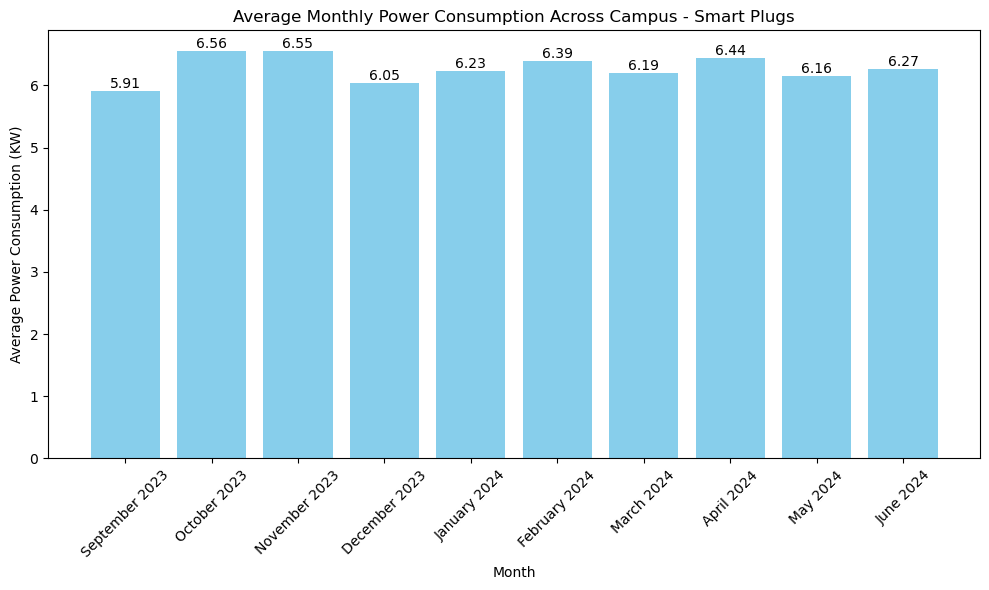

In [6]:
# Creating a bar graph that shows the average power consumption across the entire dataset for each month that we have data

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Plotting the bar charts
plt.figure(figsize=(10, 6))
bars = plt.bar(monthly_df.index.strftime('%B %Y'), monthly_df['power_consumption (KW)'], color='skyblue')
plt.xlabel('Month')
plt.ylabel('Average Power Consumption (KW)')
plt.title(f'Average Monthly Power Consumption Across Campus - Smart Plugs')
plt.xticks(rotation=45)

# Adding the monthly consumption values on top of each bar for better visual presentation
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, yval, f'{yval:.2f}', ha='center', va='bottom')

plt.tight_layout()
plt.show()